# ✅ Loading Required Libraries

In [1]:
# Importing NumPy for numerical operations
import numpy as np

# Importing TensorFlow and Keras modules
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Using Matplotlib for data visualization
import matplotlib.pyplot as plt

# Suppressing unnecessary warning messages using the warnings module
import warnings
warnings.filterwarnings("ignore")

# ✅ Loading and Preprocessing the IMDb Dataset

In [2]:
# Limit the vocabulary to the 10,000 most frequent words
max_features = 10000

# Set each review to a maximum length of 100 words
maxlen = 100

# Load the IMDb dataset, including only the top 10,000 most frequent words
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Pad sequences to ensure uniform length; shorter ones are filled with <PAD> tokens
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Retrieve the word-to-index mapping used in the IMDb dataset
word_index = imdb.get_word_index()

# Reverse the dictionary to get index-to-word mapping (+3 for reserved tokens in Keras)
reverse_word_index = {index + 3: word for word, index in word_index.items()}

# Assign special tokens:
reverse_word_index[0] = "<PAD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNK>"     # Unknown words
reverse_word_index[3] = "<UNUSED>"

In [3]:
reverse_word_index

{34704: 'fawn',
 52009: 'tsukino',
 52010: 'nunnery',
 16819: 'sonja',
 63954: 'vani',
 1411: 'woods',
 16118: 'spiders',
 2348: 'hanging',
 2292: 'woody',
 52011: 'trawling',
 52012: "hold's",
 11310: 'comically',
 40833: 'localized',
 30571: 'disobeying',
 52013: "'royale",
 40834: "harpo's",
 52014: 'canet',
 19316: 'aileen',
 52015: 'acurately',
 52016: "diplomat's",
 25245: 'rickman',
 6749: 'arranged',
 52017: 'rumbustious',
 52018: 'familiarness',
 52019: "spider'",
 68807: 'hahahah',
 52020: "wood'",
 40836: 'transvestism',
 34705: "hangin'",
 2341: 'bringing',
 40837: 'seamier',
 34706: 'wooded',
 52021: 'bravora',
 16820: 'grueling',
 1639: 'wooden',
 16821: 'wednesday',
 52022: "'prix",
 34707: 'altagracia',
 52023: 'circuitry',
 11588: 'crotch',
 57769: 'busybody',
 52024: "tart'n'tangy",
 14132: 'burgade',
 52026: 'thrace',
 11041: "tom's",
 52028: 'snuggles',
 29117: 'francesco',
 52030: 'complainers',
 52128: 'templarios',
 40838: '272',
 52031: '273',
 52133: 'zaniacs',

# ✅ Decoding and Displaying Reviews

In [4]:
# Converts numerical data back into readable text
def decode_review(encoded_review):
    return " ".join([reverse_word_index.get(i, "?") for i in encoded_review])

# Randomly select 3 reviews from the training set
random_indices = np.random.choice(len(x_train), size=3, replace=False)

# Print the selected reviews and their corresponding labels
for i in random_indices:
    print(f"Review: {decode_review(x_train[i])}")
    print(f"Label: {y_train[i]}")
    print()

Review: he chose the girl br br the great part about this movie that focuses on a person's ability to learn right from wrong over time and a child's ability to cope with the natural <UNK> of death of their pet is that it never shows anyone dying the watch <UNK> his life and the watch is shown being <UNK> and stopped all the deaths were suggestive even for the villain i didn't cry during this movie until now and i have gotten so much more out of it that i had to write it down and share it with you
Label: 1

Review: between civil rights leader steve biko and donald woods the first half of the film is the strongest where we see the bond formed between the two men and how they help each other out but the second half isn't as strong due to the <UNK> of the biko character still its a compelling film with great performances by kline and washington in the film that put the latter on the map washington was also was nominated for best supporting actor for the first time overall a well made film 

# 🧱 TransformerBlock Class

In [9]:
# Defines a single Transformer block
class TransformerBlock(layers.Layer):

    def __init__(self, embed_size, heads, dropout_rate=0.3):
        super(TransformerBlock, self).__init__()

        # Multi-head self-attention mechanism
        self.attention = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_size)

        # normalization layers
        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        # Feed-forward neural network (2 fully connected layers)
        self.feed_forward = models.Sequential([
            layers.Dense(embed_size * 4, activation="relu"),  # Hidden layer
            layers.Dense(embed_size)  # Project back to input size
        ])

        # Dropout layers to reduce overfitting
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, x, training):
        # Apply self-attention
        attention = self.attention(x, x, training=training)

        # First normalization and residual connection
        x = self.norm1(x + self.dropout1(attention, training=training))

        # Feed-forward pass + dropout + second normalization
        feed_forward = self.feed_forward(x)
        return self.norm2(x + self.dropout2(feed_forward, training=training))

# 📦 TransformerModel

In [10]:
# Defining our own transformer-based classification model
class TransformerModel(models.Model):

    def __init__(self, num_layers, embed_size, heads, input_dim, output_dim, dropout_rate=0.2):
        super(TransformerModel, self).__init__()

        # 🔤 Embedding layer: converts word indices into dense vectors
        self.embedding = layers.Embedding(input_dim=input_dim, output_dim=embed_size)

        # 🧱 Create multiple Transformer blocks (e.g., 4 layers)
        self.transformer_blocks = [
            TransformerBlock(embed_size, heads, dropout_rate)
            for _ in range(num_layers)
        ]

        # 📏 Global average pooling to reduce sequence to a fixed-length vector
        self.global_avg_pooling = layers.GlobalAveragePooling1D()

        # 💧 Dropout layer to prevent overfitting
        self.dropout = layers.Dropout(dropout_rate)

        # 🔚 Output layer: produces a single output (sigmoid for binary classification)
        self.fc = layers.Dense(output_dim, activation="sigmoid")

    def call(self, x, training):
        # 🔤 Convert input token indices to embeddings
        x = self.embedding(x)

        # 🔁 Apply each transformer block sequentially
        for transformer in self.transformer_blocks:
            x = transformer(x, training=training)

        # 📏 Reduce temporal dimension by averaging
        x = self.global_avg_pooling(x)

        # 💧 Apply dropout during training
        x = self.dropout(x, training=training)

        # 🔚 Final prediction layer (sigmoid output)
        return self.fc(x)

# ⚙️ Creating and Compiling the Transformer Model

In [11]:
# 🔢 Define core hyperparameters for the Transformer architecture
num_layers = 4            # Number of Transformer blocks to use
embed_size = 64           # Embedding vector size for each word
num_heads = 4             # Number of heads in multi-head attention
input_dim = max_features  # Maximum vocabulary size the model will handle
output_dim = 1            # Single output node for binary classification (0 or 1)
dropout_rate = 0.3        # Dropout rate (30%)

# 🧠 Instantiate the Transformer model
model = TransformerModel(num_layers, embed_size, num_heads, input_dim, output_dim, dropout_rate)

# 🏗️ Build the model by specifying the input shape (required for embedding + attention)
model.build(input_shape=(None, maxlen))  # (None, maxlen): unspecified batch size, fixed sequence length

# 🛠️ Compile the model:
# - Loss function: binary_crossentropy (for binary output)
# - Optimizer: Adam
# - Evaluation metric: Accuracy
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# 🏋️‍♂️ Training the Transformer Model

In [12]:
# 🏁 Train the model with:
# - x_train: training data
# - y_train: training labels
# - epochs=10: model will iterate over the entire dataset 10 times
# - batch_size=256: weights will be updated every 256 samples
# - validation_data: performance will be monitored on test data during training
history = model.fit(
    x_train, y_train,                 # Training data and labels
    epochs=10,                        # Train for 10 epochs
    batch_size=256,                  # Use batch size of 256
    validation_data=(x_test, y_test) # Use test data for validation
)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 336s 3s/step - accuracy: 0.5911 - loss: 0.7009 - val_accuracy: 0.8307 - val_loss: 0.3738
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.8710 - loss: 0.3115 - val_accuracy: 0.8442 - val_loss: 0.3583
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.9098 - loss: 0.2339 - val_accuracy: 0.8362 - val_loss: 0.4160
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.9303 - loss: 0.1885 - val_accuracy: 0.8282 - val_loss: 0.4610
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.9413 - loss: 0.1618 - val_accuracy: 0.8297 - val_loss: 0.4763
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.9586 - loss: 0.1272 - val_accuracy: 0.8278 - val_loss: 0.5656
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.9657 - loss: 0.1068 - val_accuracy: 0.8155 - val_loss: 0.6294
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 306s 3s/step - accuracy: 0.9765 - loss: 0.0791 - val_accuracy: 0.8073 - v

# 📈 Visualizing the Training Process

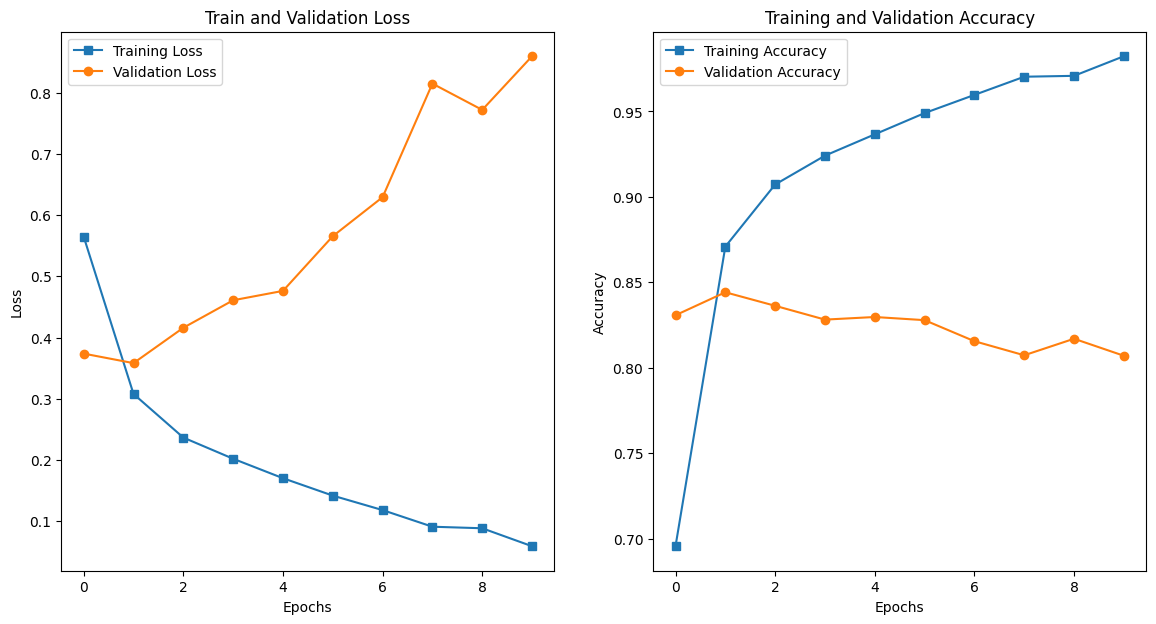

In [14]:
# Access the raw dictionary of metrics from the history object
history = history.history

# Create a figure with 2 plots in one row
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# --- Loss Plot ---
ax[0].plot(history["loss"], "s-", label="Training Loss")         # Plot training loss
ax[0].plot(history["val_loss"], "o-", label="Validation Loss")   # Plot validation loss
ax[0].set_xlabel("Epochs")              # Label for X-axis
ax[0].set_ylabel("Loss")                # Label for Y-axis
ax[0].set_title("Train and Validation Loss")  # Title
ax[0].legend()                          # Show legend

# --- Accuracy Plot ---
ax[1].plot(history["accuracy"], "s-", label="Training Accuracy")         # Plot training accuracy
ax[1].plot(history["val_accuracy"], "o-", label="Validation Accuracy")   # Plot validation accuracy
ax[1].set_xlabel("Epochs")                # Label for X-axis
ax[1].set_ylabel("Accuracy")              # Label for Y-axis
ax[1].set_title("Training and Validation Accuracy")  # Title
ax[1].legend()                            # Show legend

# --- Display all plots ---
plt.show()

# 🧠 Sentiment Prediction Based on User Review

In [15]:
# Function to process user input and make a sentiment prediction using the model
def predict_sentiment(model, text, word_index, maxlen):
    
    # Convert the input text to lowercase, split into words, and convert each word to its index
    encoded_text = [word_index.get(word, 0) for word in text.lower().split()]
    
    # Apply padding to match the model's expected input length
    padded_text = pad_sequences([encoded_text], maxlen=maxlen)
    
    # Make prediction using the trained model
    prediction = model.predict(padded_text)
    
    # Return the predicted score (between 0 and 1)
    return prediction[0][0]

# Load the IMDb word index mapping again
word_index = imdb.get_word_index()

# Get a movie review from the user
user_input = input("Enter a movie review: ")

# Predict the sentiment score for the given review
sentiment_score = predict_sentiment(model, user_input, word_index, maxlen)

# If the score is above 0.5, the sentiment is positive; otherwise, it's negative
if sentiment_score > 0.5:
    print(f"Predicted sentiment: Positive -> Score: {sentiment_score:.2f}")
else:
    print(f"Predicted sentiment: Negative -> Score: {sentiment_score:.2f}")

Enter a movie review:  The movie was incredibly boring and too long. I almost fell asleep.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted sentiment: Positive -> Score: 0.77
